### Задача: 
на основании открытых данных о судах и бухгалтерской отчетности предприятия сформировать датасет и обучить модель для прогнозирования вероятности банкротства компании

Для начала необходимо провести предварительную обработку исходных данных, понять какие показатели можно использовать для построения модели машинного обучения, ну и создать затем саму модель.

In [1]:
import numpy as np
import pandas as pd
import pickle
import os 
import fnmatch
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# загрузим данные об активах и задолженности компаний
# несколько предприятий было убрано для последующего тестирования работы модели
df_accounts = pd.read_csv('df_accounts_sample_modify.csv', sep=',')
df_accounts

,Unnamed: 0,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,0,2465002653,2012,0.0,113756.0,122240.0,384
1,1,3505003270,2012,21461.0,20211.0,81132.0,384
2,2,3517003250,2012,0.0,0.0,48063.0,384
3,3,5501078737,2012,0.0,288763.0,419522.0,384
4,4,6140019517,2012,0.0,0.0,11089.0,384
...,...,...,...,...,...,...,...
1020,1020,7814290213,2020,0.0,2728.0,71922.0,384
1021,1021,7842353970,2019,17.0,4863.0,17949.0,384
1022,1022,7842353970,2020,0.0,2548.0,16411.0,384
1023,1023,8908001998,2019,0.0,8636.0,130731.0,384


In [3]:
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          1025 non-null   int64  
 1   inn                                 1025 non-null   int64  
 2   year                                1025 non-null   int64  
 3   long_term_liabilities_fiscal_year   1025 non-null   float64
 4   short_term_liabilities_fiscal_year  1025 non-null   float64
 5   balance_assets_fiscal_year          1025 non-null   float64
 6   okei                                1025 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 56.2 KB


In [4]:
# приведем в порядок имена колонок и типы данных, значения NaN заменим нулями
df_accounts.rename(columns={'Unnamed: 0': 'id',
                            'long_term_liabilities_fiscal_year': 'long_liabilities',
                            'short_term_liabilities_fiscal_year': 'short_liabilities',
                            'balance_assets_fiscal_year': 'balance_assets'}, inplace=True)
df_accounts.set_index('id', inplace=True)
df_accounts.fillna(0, inplace=True)
df_accounts = df_accounts.astype({'year': 'int16',
                                  'short_liabilities': 'float64',
                                  'balance_assets': 'float64',
                                  'okei': 'int16'})
df_accounts

,inn,year,long_liabilities,short_liabilities,balance_assets,okei
id,,,,,,
0,2465002653,2012,0.0,113756.0,122240.0,384
1,3505003270,2012,21461.0,20211.0,81132.0,384
2,3517003250,2012,0.0,0.0,48063.0,384
3,5501078737,2012,0.0,288763.0,419522.0,384
4,6140019517,2012,0.0,0.0,11089.0,384
...,...,...,...,...,...,...
1020,7814290213,2020,0.0,2728.0,71922.0,384
1021,7842353970,2019,17.0,4863.0,17949.0,384
1022,7842353970,2020,0.0,2548.0,16411.0,384


In [5]:
df_accounts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1025 entries, 0 to 1024
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inn                1025 non-null   int64  
 1   year               1025 non-null   int16  
 2   long_liabilities   1025 non-null   float64
 3   short_liabilities  1025 non-null   float64
 4   balance_assets     1025 non-null   float64
 5   okei               1025 non-null   int16  
dtypes: float64(3), int16(2), int64(1)
memory usage: 44.0 KB


In [6]:
# кол-во предприятий в базе
df_accounts.inn.nunique()

164

In [7]:
# загрузим данные о компаниях, претерпевших банкротство
df_bankruptcies = pd.read_csv('df_bankruptcies_sample.csv', sep=',')
df_bankruptcies

,Unnamed: 0,bankrupt_id,bancrupt_year,inn
0,0,79546,2015,5620006322
1,1,76594,2015,2111008200
2,2,94301,2016,5414100369
3,3,93799,2019,2347009476
4,4,199671,2018,7224008489
...,...,...,...,...
101,101,530816,2021,7728812071
102,102,325608,2019,6154086295
103,103,339365,2020,6627020656
104,104,527279,2021,2465002653


In [8]:
df_bankruptcies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Unnamed: 0     106 non-null    int64
 1   bankrupt_id    106 non-null    int64
 2   bancrupt_year  106 non-null    int64
 3   inn            106 non-null    int64
dtypes: int64(4)
memory usage: 3.4 KB


In [9]:
# приведем в порядок имена колонок и типы данных
df_bankruptcies.rename(columns={'Unnamed: 0': 'id', 
                                'bancrupt_year': 'bankrupt_year'}, inplace=True)
df_bankruptcies.set_index('id', inplace=True)
df_bankruptcies = df_bankruptcies.astype({'bankrupt_year': 'int16'})
df_bankruptcies

,bankrupt_id,bankrupt_year,inn
id,,,
0,79546,2015,5620006322
1,76594,2015,2111008200
2,94301,2016,5414100369
3,93799,2019,2347009476
4,199671,2018,7224008489
...,...,...,...
101,530816,2021,7728812071
102,325608,2019,6154086295
103,339365,2020,6627020656


In [10]:
df_bankruptcies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   bankrupt_id    106 non-null    int64
 1   bankrupt_year  106 non-null    int16
 2   inn            106 non-null    int64
dtypes: int16(1), int64(2)
memory usage: 2.7 KB


In [11]:
# данные об участиях предприятий в арбитражах хранятся в файлах тип '*.pkl' в папке 'success'
# получим список файлов

list_files = []
for file_name in os.listdir('success'):  
    if fnmatch.fnmatch(file_name, '*.pkl'):
        list_files.append(file_name)

In [12]:
# загрузим данные из файлов в датафрейм 'df_court_cases'
# каждый pkl-файл хранит сведения об участии предприятия в арбитражных делах
# поле case_sides.type принимает значения: 
# 0 - 'истец', 1 - 'ответчик', 2 - 'свидетель', 3 - 'конкурсный управляющий' 
# (type 3 был выявлен при анализе pkl-файлов)
# для подсчета кол-ва участий по каждому типу стороны дела будем пользоваться словарем

df_court_cases = pd.DataFrame(columns=['inn', 'year', 0, 1, 2, 3])

for file_name in list_files:
    with open('success/'+file_name, 'rb') as f:
        data = pickle.load(f)
    
    inn = data['inn']
    
    court_case = dict()    
    for i in range(len(data['cases_list'])):
        year = pd.to_datetime(data['cases_list'][i]['caseDate']).year
        if year not in court_case:
            court_case[year] = {'inn': inn, 'year': year, 0: 0, 1: 0, 2: 0, 3: 0}
        count_case_sides = len(data['cases_list'][i]['case_sides'])
        for j in range(count_case_sides):
            if data['cases_list'][i]['case_sides'][j]['INN'] == str(inn):
                court_case[year][data['cases_list'][i]['case_sides'][j]['type']] += 1

    court_case_list = [x for x in court_case.values()]
    
    df_court_cases = df_court_cases.append(court_case_list, ignore_index=True)

In [13]:
# дадим 'осмысленные' названия столбцам и приведем в порядок типы данных
df_court_cases.rename(columns={0: 'applicant', 1: 'responder', 2: 'witness', 3: 'bankrupt_trustee'}, inplace=True)
df_court_cases = df_court_cases.astype({'inn': 'int64',
                                        'year': 'int16',
                                        'applicant': 'int16',
                                        'responder': 'int16',
                                        'witness': 'int16',
                                        'bankrupt_trustee': 'int16'})
df_court_cases

,inn,year,applicant,responder,witness,bankrupt_trustee
0,1001003743,2020,1,0,0,0
1,1001003743,2014,1,0,0,0
2,1001003743,2010,2,0,0,0
3,1020010136,2020,0,1,0,0
4,1020010136,2019,2,1,0,0
...,...,...,...,...,...,...
1150,8909000186,2017,0,9,0,0
1151,8909000186,2016,0,6,0,0
1152,8909000186,2015,0,9,0,0
1153,8909000186,2014,0,2,0,0


In [14]:
df_court_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   inn               1155 non-null   int64
 1   year              1155 non-null   int16
 2   applicant         1155 non-null   int16
 3   responder         1155 non-null   int16
 4   witness           1155 non-null   int16
 5   bankrupt_trustee  1155 non-null   int16
dtypes: int16(5), int64(1)
memory usage: 20.4 KB


In [15]:
# посмотрим на полученные данные на примере предприятия inn 1020010136
df_court_cases[df_court_cases['inn'] == 1020010136].sort_values(by='year')

,inn,year,applicant,responder,witness,bankrupt_trustee
7,1020010136,2016,1,18,1,0
6,1020010136,2017,8,20,3,0
5,1020010136,2018,2,28,1,2
4,1020010136,2019,2,1,0,0
3,1020010136,2020,0,1,0,0


In [16]:
# поле 'okei' хранит код: 383 - руб., 384 - тыс.руб., 385 - млн.руб.
df_accounts['okei'].value_counts()

384    1021
383       4
Name: okei, dtype: int64

In [17]:
# для всех предприятий приведем к тыс.руб. данные об обязательствах и баланс

def calc(x, y):
    if y == 383:
        x /= 1000
    elif y == 385:
        x *= 1000
    return x

df_accounts['long_liabilities_th'] = df_accounts.apply(lambda x: calc(x['long_liabilities'], x['okei']), axis=1)
df_accounts['short_liabilities_th'] = df_accounts.apply(lambda x: calc(x['short_liabilities'], x['okei']), axis=1)
df_accounts['balance_assets_th'] = df_accounts.apply(lambda x: calc(x['balance_assets'], x['okei']), axis=1)

Для построения модели соберем все сведения в единый датасет.

В качестве фичей (признаков) модели предлагается использовать поля:
* long_liabilities_th - долгосрочные обязательства предприятия, тыс.руб.
* short_liabilities_th - краткосрочные обязательства предприятия, тыс.руб.
* balance_assets_th - балансовые активы предпрития, тыс.руб.
* applicant - кол-во участий предприятия в арбитражах в качестве истца (до даты банкротства)
* responder - кол-во участий предприятия в арбитражах в качестве ответчика (до даты банкротства)
* witness - кол-во участий предприятия в арбитражах в качестве свидетеля (до даты банкротства)
* bankrupt_trustee - кол-во участий предприятия в арбитражах в качестве конкурсного управляющего (до даты банкротства)

In [18]:
# соберем все сведения о предприятиях в единый датафрейм 'df_firms'
df_firms = pd.merge(df_accounts, df_court_cases, on=['inn', 'year'], how='outer') 
df_firms = pd.merge(df_firms, df_bankruptcies, left_on=['inn'], right_on=['inn'], how='outer') 
df_firms.drop(['long_liabilities', 'short_liabilities', 'balance_assets', 'okei', 'bankrupt_id'], axis=1, inplace=True)
df_firms.fillna(0, inplace=True)
df_firms

,inn,year,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_year
0,2465002653,2012.0,0.0,113756.0,122240.0,3.0,1.0,0.0,0.0,2021.0
1,2465002653,2013.0,0.0,212584.0,241577.0,8.0,2.0,0.0,1.0,2021.0
2,2465002653,2017.0,0.0,51779.0,76710.0,24.0,1.0,1.0,3.0,2021.0
3,2465002653,2014.0,0.0,63670.0,95167.0,3.0,4.0,0.0,0.0,2021.0
4,2465002653,2015.0,0.0,25896.0,52292.0,2.0,8.0,1.0,0.0,2021.0
...,...,...,...,...,...,...,...,...,...,...
1562,7733535610,2012.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1563,7733535610,2010.0,0.0,0.0,0.0,1.0,6.0,2.0,0.0,0.0
1564,7733535610,2009.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1565,7733535610,2006.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
df_firms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1567 entries, 0 to 1566
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   inn                   1567 non-null   int64  
 1   year                  1567 non-null   float64
 2   long_liabilities_th   1567 non-null   float64
 3   short_liabilities_th  1567 non-null   float64
 4   balance_assets_th     1567 non-null   float64
 5   applicant             1567 non-null   float64
 6   responder             1567 non-null   float64
 7   witness               1567 non-null   float64
 8   bankrupt_trustee      1567 non-null   float64
 9   bankrupt_year         1567 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 134.7 KB


In [20]:
# приведем в порядок типы данных
df_firms = df_firms.astype({'year': 'int16',
                            'long_liabilities_th': 'float64',
                            'short_liabilities_th': 'float64',
                            'balance_assets_th': 'float64',
                            'applicant': 'int16',
                            'responder': 'int16',
                            'witness': 'int16',
                            'bankrupt_trustee': 'int16',
                            'bankrupt_year': 'int16',
                           })
df_firms

,inn,year,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_year
0,2465002653,2012,0.0,113756.0,122240.0,3,1,0,0,2021
1,2465002653,2013,0.0,212584.0,241577.0,8,2,0,1,2021
2,2465002653,2017,0.0,51779.0,76710.0,24,1,1,3,2021
3,2465002653,2014,0.0,63670.0,95167.0,3,4,0,0,2021
4,2465002653,2015,0.0,25896.0,52292.0,2,8,1,0,2021
...,...,...,...,...,...,...,...,...,...,...
1562,7733535610,2012,0.0,0.0,0.0,0,3,0,0,0
1563,7733535610,2010,0.0,0.0,0.0,1,6,2,0,0
1564,7733535610,2009,0.0,0.0,0.0,0,3,0,0,0
1565,7733535610,2006,0.0,0.0,0.0,0,1,0,0,0


In [21]:
df_firms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1567 entries, 0 to 1566
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   inn                   1567 non-null   int64  
 1   year                  1567 non-null   int16  
 2   long_liabilities_th   1567 non-null   float64
 3   short_liabilities_th  1567 non-null   float64
 4   balance_assets_th     1567 non-null   float64
 5   applicant             1567 non-null   int16  
 6   responder             1567 non-null   int16  
 7   witness               1567 non-null   int16  
 8   bankrupt_trustee      1567 non-null   int16  
 9   bankrupt_year         1567 non-null   int16  
dtypes: float64(3), int16(6), int64(1)
memory usage: 79.6 KB


In [22]:
# посмотрим сведения, например, для предприятия inn 1020010136
df_firms[df_firms['inn'] == 1020010136].sort_values(by='year')

,inn,year,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_year
1495,1020010136,2015,0.0,3900.0,3451.0,0,0,0,0,2018
1496,1020010136,2016,0.0,16187.0,12526.0,1,18,1,0,2018
1494,1020010136,2017,0.0,36750.0,14769.0,8,20,3,0,2018
1497,1020010136,2018,0.0,55297.0,14589.0,2,28,1,2,2018
1499,1020010136,2019,0.0,0.0,0.0,2,1,0,0,2018
1498,1020010136,2020,0.0,0.0,0.0,0,1,0,0,2018


In [23]:
# оставим только данные, предшевствующие дате банкротства
df_firms = df_firms[(df_firms['bankrupt_year'] == 0) | (df_firms['year'] <= df_firms['bankrupt_year'])]
df_firms

,inn,year,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_year
0,2465002653,2012,0.0,113756.0,122240.0,3,1,0,0,2021
1,2465002653,2013,0.0,212584.0,241577.0,8,2,0,1,2021
2,2465002653,2017,0.0,51779.0,76710.0,24,1,1,3,2021
3,2465002653,2014,0.0,63670.0,95167.0,3,4,0,0,2021
4,2465002653,2015,0.0,25896.0,52292.0,2,8,1,0,2021
...,...,...,...,...,...,...,...,...,...,...
1562,7733535610,2012,0.0,0.0,0.0,0,3,0,0,0
1563,7733535610,2010,0.0,0.0,0.0,1,6,2,0,0
1564,7733535610,2009,0.0,0.0,0.0,0,3,0,0,0
1565,7733535610,2006,0.0,0.0,0.0,0,1,0,0,0


In [24]:
# сгруппируем даные о предприятии и просуммируем кол-во сведений об участии в арбитражах,
# а данные об обязательствах и баланс возьмем по последнему году
# добавим еще один признак - кол-во лет предприятию
# (в данном случае кол-во наблюдений, т.к. у нас нет информации о дате создания предприятия)
df_firms_agg = df_firms.sort_values(by=['inn','year']).groupby('inn', as_index=False).\
    agg(year=('year', 'last'),
        count_years=('year', 'count'),
        long_liabilities_th=('long_liabilities_th', 'last'),
        short_liabilities_th=('short_liabilities_th', 'last'),
        balance_assets_th=('balance_assets_th', 'last'),
        applicant=('applicant', 'sum'),
        responder=('responder', 'sum'),
        witness=('witness', 'sum'),
        bankrupt_trustee=('bankrupt_trustee', 'sum'),
        bankrupt_year=('bankrupt_year', 'last')
       )

In [25]:
# добавим поле 'bankrupt' - целевой признак
df_firms_agg['bankrupt'] = [1 if x != 0 else 0 for x in df_firms_agg['bankrupt_year']]
df_firms_agg.drop(['year', 'bankrupt_year'], axis=1, inplace=True)
df_firms_agg.set_index('inn', inplace=True)
df_firms_agg

,count_years,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt
inn,,,,,,,,,
1001003743,10,0.0,0.0,0.0,4,0,0,0,0
1020010136,4,0.0,55297.0,14589.0,11,66,5,2,1
1203000142,20,52005.0,315556.0,442374.0,196,205,31,30,1
1302000640,1,0.0,0.0,0.0,0,0,0,0,1
1411004211,7,0.0,0.0,0.0,1,13,1,0,1
...,...,...,...,...,...,...,...,...,...
7842353970,12,0.0,0.0,0.0,12,24,5,3,0
8617004112,5,0.0,0.0,0.0,0,27,1,0,1
8901998318,6,0.0,0.0,0.0,0,1,0,0,0


Датасет готов для формирования и обучения модели

In [26]:
# разделим датасет на две части: признаки для модели и целевую переменную
X = df_firms_agg.drop('bankrupt', axis=1)
y = df_firms_agg['bankrupt']

In [27]:
X

,count_years,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee
inn,,,,,,,,
1001003743,10,0.0,0.0,0.0,4,0,0,0
1020010136,4,0.0,55297.0,14589.0,11,66,5,2
1203000142,20,52005.0,315556.0,442374.0,196,205,31,30
1302000640,1,0.0,0.0,0.0,0,0,0,0
1411004211,7,0.0,0.0,0.0,1,13,1,0
...,...,...,...,...,...,...,...,...
7842353970,12,0.0,0.0,0.0,12,24,5,3
8617004112,5,0.0,0.0,0.0,0,27,1,0
8901998318,6,0.0,0.0,0.0,0,1,0,0


Для создания модели воспользуемся алгоритмом 'RandomForest'

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
clf = RandomForestClassifier(n_estimators=100,
                             min_samples_split=2,
                             min_samples_leaf=2,
                             max_features='sqrt',
                             max_depth=5,
                             bootstrap=False,
                             random_state=42)

In [30]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, random_state=42)

Для подбора гиперпараметров можно воспользоваться RandomizedSearchCV

In [31]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 10, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
rs = RandomizedSearchCV(clf, 
                        param_dist, 
                        n_iter=20, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    max_depth=5,
                                                    max_features='sqrt',
                                                    min_samples_leaf=2,
                                                    random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 2, 3, 4, 5, 6,
                                                              7, 8, 9

In [32]:
rs.best_params_

{'n_estimators': 322,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'log2',
 'max_depth': 4,
 'bootstrap': True}

In [33]:
rs_clf = rs.best_estimator_

In [34]:
y_pred = rs_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.94      0.81      0.87        21

    accuracy                           0.85        34
   macro avg       0.85      0.87      0.85        34
weighted avg       0.87      0.85      0.85        34



Неплохие показатели качества работы модели:
* accuracy - 85%
* precision - 94%
* F1 - 87%

In [35]:
# посмотрим на важность признаков
feature_imp = pd.Series(rs_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

responder               0.483314
count_years             0.178445
short_liabilities_th    0.117192
balance_assets_th       0.076853
applicant               0.072173
witness                 0.036277
bankrupt_trustee        0.027819
long_liabilities_th     0.007927
dtype: float64

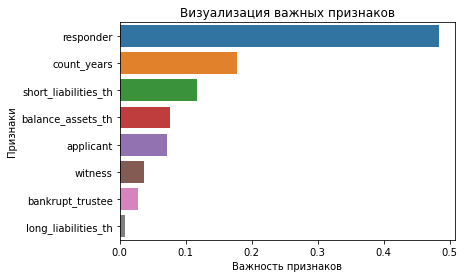

In [36]:
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()


Наиболее значимыми признаками оказались: responder, count_years, short_liabilities_th, applicant и balance_assets_th.

Суммарно они дают более 90% влияния на результат работы модели по оценке предпрития на возможное банкротство.

In [37]:
# для сравнения, посмотрим на реальный факт банкротсва и предсказанный нашей моделью
df_y_test = pd.DataFrame(y_test)

df_y_pred = pd.DataFrame(y_pred, columns=['bankrupt_pred'])
df_y_pred['inn'] = df_y_test.index
df_y_pred.set_index('inn', inplace=True)

df_pred = pd.merge(df_y_test, df_y_pred, on='inn', how='inner')
df_pred

,bankrupt,bankrupt_pred
inn,,
6105002983,1,1
7701568235,1,0
5230002690,1,1
3851005241,0,0
5945001214,1,1
2611005373,0,0
6205005875,0,0
5406339932,1,1
8617004112,1,1


In [38]:
# предприятия, у которых реальные сведения о банкротстве не совпали с предсказанными
df_wrong = df_pred[df_pred['bankrupt'] != df_pred['bankrupt_pred']]
df_wrong

,bankrupt,bankrupt_pred
inn,,
7701568235,1,0
3436108015,1,0
2719008034,1,0
4347021100,0,1
7707705992,1,0


In [39]:
# посмотрим на признаки предприятий, у которых прогноз не совпал с фактом
pd.merge(df_firms_agg, df_wrong, on='inn', how='inner').sort_values(by='inn')

,count_years,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_x,bankrupt_y,bankrupt_pred
inn,,,,,,,,,,,
2719008034,1,0.0,20572.0,4965.0,1,1,0,0,1,1,0
3436108015,8,13705.0,8327.0,10180.0,2,1,0,0,1,1,0
4347021100,11,0.0,0.0,0.0,0,36,2,2,0,0,1
7701568235,4,0.0,85686.0,83163.0,5,1,0,0,1,1,0
7707705992,7,0.0,0.0,0.0,7,3,0,1,1,1,0


In [40]:
# можно также посмотреть и на полные сведения предприятий, у которых прогноз не совпал с фактом
# и проанализировать, в чем может быть проблема работы модели
pd.merge(df_firms, df_wrong, on='inn', how='inner').sort_values(by=['inn', 'year'])

,inn,year,long_liabilities_th,short_liabilities_th,balance_assets_th,applicant,responder,witness,bankrupt_trustee,bankrupt_year,bankrupt,bankrupt_pred
0,2719008034,2012,0.0,20572.0,4965.0,1,1,0,0,2012,1,0
23,3436108015,2012,0.0,15094.0,16578.0,0,0,0,0,2021,1,0
19,3436108015,2013,0.0,15094.0,16578.0,0,0,0,0,2021,1,0
20,3436108015,2014,0.0,17321.0,19161.0,0,0,0,0,2021,1,0
21,3436108015,2015,0.0,19361.0,21436.0,0,0,0,0,2021,1,0
22,3436108015,2016,0.0,25409.0,29174.0,0,0,0,0,2021,1,0
26,3436108015,2018,0.0,0.0,0.0,1,0,0,0,2021,1,0
24,3436108015,2019,9337.0,15563.0,28332.0,1,0,0,0,2021,1,0
25,3436108015,2020,13705.0,8327.0,10180.0,0,1,0,0,2021,1,0
18,4347021100,2009,0.0,0.0,0.0,0,1,0,0,0,0,1


Явно выделяется предприятие inn 4347021100, которому наша модель предсказала банкротство, но в реальности его не было.
Если внимательно посмотреть на признаки предприятия, можно предположить, что модель предсказала банкротсво из-за большого кол-ва участия данного предприятия в арбитражах в качестве ответчика (как было показано ранее, 'responder' - самый значимый признак в моделе). Но видимо участие в качестве ответчика предприятия не всегда означает что-то плохое и ведущее к банкротсву - нужно тогда анализировать уже сами арбитражные процессы.

In [41]:
# сохраним обученную модель в файл для дальнейшего использования
model_filename = 'model.sav'
pickle.dump(rs_clf, open(model_filename, 'wb'))